In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-08-08 15:24:30.881138: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 15:24:30.881302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 15:24:31.060442: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

In [3]:
X = []
Y = []

IMAGE_RES = 256

path = '/kaggle/input/brain-tumor-classification-mri'

labels_len = {}
for label in labels:
    labels_len[label] = 0


for label in labels:
    folder_path = os.path.join(path,'Training',label)
    for image in tqdm(os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path,image))
        img = cv2.resize(img,(IMAGE_RES,IMAGE_RES))
        
        labels_len[label] += 1
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=5)
        img = clahe.apply(img) + 30
        
        img = cv2.merge((img,img,img))
        
        
        X.append(img)
        Y.append(label)
        
for label in labels:
    folder_path = os.path.join(path,'Testing',label)
    for image in tqdm(os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path,image))
        img = cv2.resize(img,(IMAGE_RES,IMAGE_RES))
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=5)
        img = clahe.apply(img) + 30
        
        labels_len[label] += 1
        
        img = cv2.merge((img,img,img))
           
        X.append(img)
        Y.append(label)
        



100%|██████████| 74/74 [00:01<00:00, 68.67it/s]



os.listdir = bir folderdaki dosyaları itere eder.


In [4]:
print(str(labels_len['glioma_tumor']))

926


<BarContainer object of 4 artists>

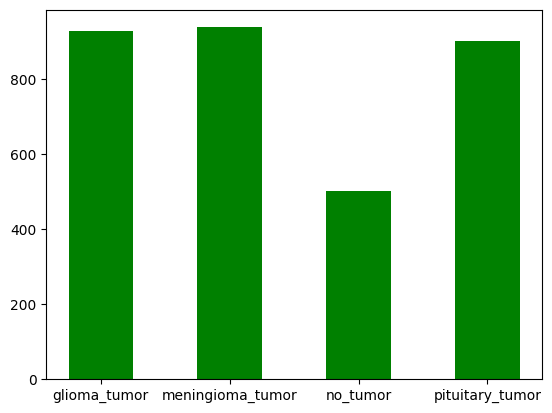

In [5]:
plt.bar(labels_len.keys(), labels_len.values(), 0.5, color='g')

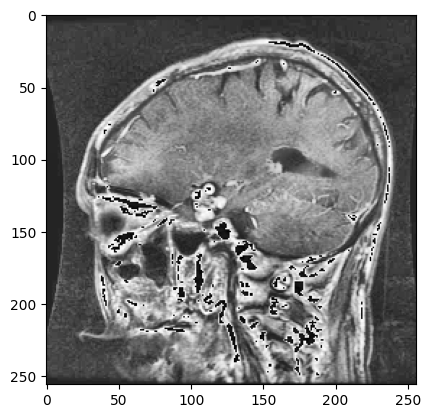

In [6]:
plt.imshow(X[90],cmap='gray')

In [7]:
from sklearn.utils import shuffle
X, Y = shuffle(X,Y, random_state=101)

In [8]:
X = np.array(X)
Y = np.array(Y)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.1,random_state=101)

In [9]:
onehot_y_train = []
for i in Y_train:
    onehot_y_train.append(labels.index(i))
    
Y_train = tf.keras.utils.to_categorical(onehot_y_train)

onehot_y_test = []

for i in Y_test:
    onehot_y_test.append(labels.index(i))
    
Y_test = tf.keras.utils.to_categorical(onehot_y_test)


In [10]:
effnet = tf.keras.applications.EfficientNetB0(weights='imagenet',include_top=False,input_shape=(IMAGE_RES,IMAGE_RES,3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
model= effnet.output
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Flatten()(model)
model = tf.keras.layers.Dense(units=4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [12]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])


In [ ]:
history = model.fit(X_train,Y_train,validation_split=0.1, epochs =10, verbose=1, batch_size=32)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 710s 8s/step - accuracy: 0.6841 - loss: 1.6467 - val_accuracy: 0.8367 - val_loss: 1.5305
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 648s 8s/step - accuracy: 0.8777 - loss: 0.6704 - val_accuracy: 0.8844 - val_loss: 0.5055
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 636s 8s/step - accuracy: 0.9226 - loss: 0.3656 - val_accuracy: 0.8673 - val_loss: 1.1066
Epoch 4/10
11/83 ━━━━━━━━━━━━━━━━━━━━ 8:54 7s/step - accuracy: 0.9637 - loss: 0.2038

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 4,377,255 (16.70 MB)

 Trainable params: 4,335,232 (16.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [14]:
X_train.shape


(2937, 256, 256, 3)

In [15]:
Y_train.shape

(2937, 4)

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(Y_test,axis=1)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_new,pred))

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']
import seaborn as sns
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()